# Capstone Project - The Battle of Neighborhoods (Week 1)
## Analyzing Geospatial Data using Foursquare and Python

__created by MaroDataVision__

## Introduction

### Problem Description

This is about a problem which all visionaires are confronted with: __Searching the right place for establishing your company__. 
\
\
As I am starting my data science and machine learning career, I was wondering where to place a __Data Science Start-Up__ near by my residence. The city to look for a good place should be __Frankfurt in Germany__. But what are the expectations of such a location. So the idea I had was to look for existing and good rated Data Science companies (in Germany) and analyze their locations for comparing them to the neighborhoods in Frankfurt. 

### Business Question

The challenging part about this project is to generate features from location data of Data Science companies for clustering the neighborhoods in Frankfurt to answer the question: 
#### __Where to place my Data Science Start-Up in Frankfurt, Germany to get the best environment for workmates and customers?__

### Addressed Audience
In this project several important techniques are covert to collect environmental data about company locations and apply that data to a selection of locations in destination city. So in short this is interesting for all those future entrepreneurs considering to start a business in a selected city. 

## Data

### Required Data
To answer the __Business Question__ the following data is required:
* zips, neighborhoods and their coordinates in Frankfurt
* zips, neighborhoods and their coordinates of german data science companies
* venues in neighborhoods in Frankfurt
* venues nearby german data science companies

### How the data will be used answer the question
* Use Foursquare and pgeocode (geopy doesn't work here) to get:
 1. the top 10 venues nearby german data science companies
 1. venues nearby neighborhoods in Frankfurt
* Use only companies with german address
* Analyze the venues nearby german data science companies and look for similarities between the different locations
* Apply the results of the analysis to the venues of the neighborhoods in Frankfurt
* Map the data with folium to visualize the findings

## Methodology

### Preview of Frankfurt Neighborhoods with folium

__Let's preview the neighborhoods related to their ZIP codes with folium to check the quality of the received coordinates.__

In [1]:
import pandas as pd 
import numpy as np
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pgeocode
from geopy.geocoders import Nominatim
from tqdm import tqdm_notebook

Get the latitude and longitiude of Frankfurt via google

In [2]:
latitude = 50.110924
longitude = 8.682127

I parsed the table including the __zip__ codes and __neighborhoods__ from a german zip code website and saved it in the following .csv file.

In [3]:
frankfurt_data = pd.read_csv('frankfurt_parts.csv')

In [4]:
frankfurt_data.rename({"Stadtteil": "Neighborhood", "Postleitzahl": "ZIP"}, axis=1, inplace=True)
frankfurt_data.head()

,Neighborhood,ZIP
0,Altstadt,"60311, 60313"
1,Bahnhofsviertel,60329
2,Bergen-Enkheim,"60388, 60389"
3,Berkersheim,60435
4,Bockenheim,"60325, 60431, 60486, 60487"


Split the comma seperated ZIP codes and insert for every ZIP code a new row with the same Neighborhood.

In [5]:
frankfurt_df = frankfurt_data.assign(ZIP=frankfurt_data['ZIP'].str.split(',')).explode('ZIP').reset_index(drop=True)

Group the dataframe by the ZIPs and join the Neighborhoods with commas.

In [6]:
print("shape before grouping zips: {}".format(frankfurt_df.shape))
# trim whitespaces
frankfurt_df['ZIP'] = frankfurt_df['ZIP'].str.strip()
fr_df = frankfurt_df.groupby('ZIP')['Neighborhood'].apply(lambda x: ", ".join(x)).to_frame().reset_index()
print("shape after grouping zips: {}".format(fr_df.shape))
fr_df.head()

shape before grouping zips: (116, 2)
shape after grouping zips: (42, 2)


,ZIP,Neighborhood
0,60306,Westend-Süd
1,60308,Westend-Süd
2,60310,Innenstadt
3,60311,"Altstadt, Innenstadt"
4,60312,Innenstadt


Initialize a __geopy__ instance with __Nominatim__ and query the ZIP codes to get the related __latitudes and longitudes__.

In [7]:
zipcoder = Nominatim(user_agent="my_awsome_app")
fr_lat_lng = []
for plz in fr_df['ZIP'].values:
    result = zipcoder.geocode(plz)
    fr_lat_lng.append(result)
# fr_lat_lng

In [8]:
lat_lng_list = {'latitude': [], 'longitude': []}
for loc in fr_lat_lng:
    lat_lng_list['latitude'].append(loc.latitude)
    lat_lng_list['longitude'].append(loc.longitude)

Merge the coordinates from the __fr_lat_lng__ dataframe with the __fr_df__ dataframe

In [9]:
frankframe = pd.concat([fr_df, pd.DataFrame(data=lat_lng_list)], axis=1)
# drop the row where we didn't receive coordinates
frankframe.dropna(axis=0, inplace=True)
frankframe.head()

,ZIP,Neighborhood,latitude,longitude
0,60306,Westend-Süd,50.116106,8.670161
1,60308,Westend-Süd,50.112301,8.652724
2,60310,Innenstadt,49.609911,2.906436
3,60311,"Altstadt, Innenstadt",50.110068,8.683168
4,60312,Innenstadt,50.111555,8.673024


__Now let's display the neighborhoods of Frankfurt via folium__

In [10]:
# create map of frankfurt using latitude and longitude values
map_frankfurt = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough in zip(frankframe['latitude'], frankframe['longitude'], frankframe['Neighborhood']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_frankfurt)  
    
map_frankfurt

### Load the scraped company data
The data science company data consist of __company name__, __rating__ und __city__.

In [14]:
# read the crawled json file (included in github repo) using pandas 
companies = pd.read_json('./CompanyCrawler/CompanyCrawler/spiders/datascience_companies.json') # adjust path
companies = companies['companies'][0]
companies[:5]

[['Sigma Data Systems', 'width:97.6%', 'Attenhofen,\xa0'],
 ['MobiDev', 'width:100%', 'Berlin,\xa0'],
 ['XenonStack', 'width:0%', 'Munich,\xa0'],
 ['Consagous Technologies', 'width:95.6%', 'Diekholzen,\xa0'],
 ['Datapine', 'width:100%', 'Berlin,\xa0']]

OK, so let's put the list in a dataframe, give it column headers and extract the relative rating value using regex

In [15]:
# create dataframe
company_df = pd.DataFrame(data=companies, columns=['company', 'rating', 'city'])
# extract ratings and cut the last 2 chars in the city column
company_df['rating'] = company_df['rating'].str.extract(':(\d+\.?\d*)%')
company_df['city'] = company_df['city'].str.extract('^(\w+),')
# make sure that the columns have the right datatypes
company_df['company'] = company_df['company'].astype(str)
company_df['rating'] = company_df['rating'].astype(float)
company_df.head()

,company,rating,city
0,Sigma Data Systems,97.6,Attenhofen
1,MobiDev,100.0,Berlin
2,XenonStack,0.0,Munich
3,Consagous Technologies,95.6,Diekholzen
4,Datapine,100.0,Berlin


Now let's write a function for requesting the company latitudes and longitudes via __geopy__. We have to iterate over the dataframe rows.

In [29]:
def get_company_coordinates(company_df):
    company_locations = {}
    for row in tqdm_notebook(company_df.iterrows()):
        # give the api 10 attempts for receiving data
        for i in range(10):
            query = "{}, {} Germany".format(row[1].company, row[1].city)
            result = zipcoder.geocode(query)
            if result:
                break
        company_locations[row[1].company] = result
    return company_locations

Calling the function __get_company_coordinates()__, pack the data into a dataframe and substitute None value with __np.nan__.

In [31]:
# assign a new column to company_df and map the company locations dict 
# for having the right coordinates for the related company
company_df['lat_lng'] = company_df['company'].map(company_locations)
# split the lat_lng column into 2 columns for each coordinate
company_df['latitude'] = company_df['lat_lng'].apply(lambda x: x.latitude if x else np.nan)
company_df['longitude'] = company_df['lat_lng'].apply(lambda x: x.longitude if x else np.nan)
company_df.head()

,company,rating,city,lat_lng,latitude,longitude
0,Sigma Data Systems,97.6,Attenhofen,None,NaN,NaN
1,MobiDev,100.0,Berlin,None,NaN,NaN
2,XenonStack,0.0,Munich,None,NaN,NaN
3,Consagous Technologies,95.6,Diekholzen,None,NaN,NaN
4,Datapine,100.0,Berlin,None,NaN,NaN


In [32]:
# let's drop all companies where we were not able to receive the coordinates (containing np.nan)
dropped_company_df = company_df.dropna(axis=0).reset_index(drop=True)
dropped_company_df

,company,rating,city,lat_lng,latitude,longitude
0,NIX,100.0,Berlin,"(coffee...nix verstehen, Oranienstraße, Kreuzb...",52.504345,13.409192
1,USU,0.0,Moglingen,"(USU Campus, 32, Wagnerstraße, Möglingen, Land...",48.885059,9.125616
2,T-Systems International GmbH,0.0,Hamburg,"(Deutsche Telekom AG, 26, Binderstraße, Rother...",53.568070,9.985293
3,NTT DATA,0.0,Munich,"(NTT DATA, 26, Hans-Döllgast-Straße, Bezirkste...",48.184123,11.587780
4,SAS,0.0,Nurnberg,"(Nürnberg, Bayern, Deutschland, (49.453872, 11...",49.453872,11.077298
5,Nagarro,0.0,Munich,"(Nagarro IT, 15, Baierbrunner Straße, Bezirkst...",48.098671,11.533771
6,X1 Group,0.0,Stuttgart,"(Westhouse Group, 10, Marktplatz, Rathaus, Stu...",48.775689,9.178211
7,Software AG,0.0,Frankfurt,"(101010 Software, 98, Gutleutstraße, Gutleutvi...",50.103850,8.663393


To save us time for running the geopy requests every time we start the notebook, just dump the __dataframe as csv__ file using pandas.

In [35]:
# dropped_company_df.to_csv("11_companies_lat_lng.csv")
dropped_company_df = pd.read_csv("11_companies_lat_lng.csv")

Let's take a look at the distribution of data science company over germany.

In [36]:
# create map of datascience companies using latitude and longitude values
# use the coordinates for frankfurt as it is almost the middle of germany
map_dsgermany = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to map
for lat, lng, company in zip(dropped_company_df['latitude'], dropped_company_df['longitude'], dropped_company_df['company']):
    label = '{}'.format(company)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dsgermany)  
    
map_dsgermany

### Get the venues nearby the data science companies using Foursquare API
At first we define a function for requesting the venue data with our Foursquare API credentials. To format the data for our purposes we also have to reshape the json data with some helper functions.

In [37]:
# filling in the credentials
client_id = "XXXXXXXXXXXXXXX"
client_secret = "XXXXXXXXXXXXXXX"
# writing the function
def get_venues_near_location(lat, lon, client_id, client_secret, radius=1000, limit=30):
    version = '20201104' # using the actual version of the API
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        # print(results)
        venues = results      
    except:
        venues = []
    return venues

In [28]:
# function for extracting the categories from json
def get_categories(categories):
    return [cat['name'] for cat in categories]

In [51]:
# function for extracting and formatting the address from json
def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', Deutschland', '')
    address = address.replace(', Germany', '')
    return address

In [20]:
# function for creating a list of the relevant data
def get_relevant_venue_data(venues_per_company):
    all_venues = {}
    for comp, vpc in venues_per_company.items():
        venues = [(item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in vpc]   
        all_venues[comp] = venues
    return all_venues

In [51]:
# function for converting the venue data to a dataframe
def venue_data_to_dataframe(all_venues, first_col="Company"):
    venues_data = []
    for company, data in all_venues.items():
        venues_data += [[company, value[0], value[1][0], value[2][0], value[2][1], value[3], value[4]] for value in data]
    column_names = [first_col, 'Venue_Name', 'Category', 'Latitude', 'Longitude', 'Address', 'Distance']
    venues_df = pd.DataFrame(data=venues_data, columns=column_names)
    return venues_df

Now we have the function in place. Let's apply them to our data science company dataframe (__dropped_company_df__).

In [98]:
# call the Foursquare API on each row in the dataframe
venues_per_company = {}
for row in dropped_company_df.iterrows():
    venues_per_company[row[1].company] = get_venues_near_location(row[1].latitude, row[1].longitude, client_id, client_secret)

In [107]:
# reshape the received json to a list of venues
all_venues = get_relevant_venue_data(venues_per_company)

In [110]:
# put the list of venues in a dataframe
venues_df = venue_data_to_dataframe(all_venues)

{'S-PRO': [('5826f422453a547f728e261f',
   'Hunky Dory',
   [('Cocktail Bar', '4bf58dd8d48988d11e941735')],
   (50.103891712844565, 8.665367323347024),
   'Baseler Straße 10, 60329 Frankfurt am Main',
   292),
  ('4dadcbfc8154b108fec69850',
   'Mr. Lee',
   [('Korean Restaurant', '4bf58dd8d48988d113941735')],
   (50.102041725035974, 8.66038392899925),
   'Gutleutstr. 153, 60327 Frankfurt am Main',
   301),
  ('4d9469351646a35dd72335a3',
   'Atlantik Fisch',
   [('Seafood Restaurant', '4bf58dd8d48988d1ce941735')],
   (50.10249368519658, 8.6614746624474),
   '60327 Frankfurt am Main',
   248),
  ('4b05884df964a52026bd22e3',
   'Villa Kennedy',
   [('Hotel', '4bf58dd8d48988d1fa931735')],
   (50.09736040302291, 8.669209385229689),
   'Kennedyallee 70 (Stresemannallee), 60596 Frankfurt am Main',
   557),
  ('4eb446216c2590eb878bda94',
   "L'Osteria",
   [('Trattoria/Osteria', '55a5a1ebe4b013909087cb7f')],
   (50.101269729761626, 8.66363704057337),
   'Speicherstraße 1, 60327 Frankfurt am Ma

In [39]:
# Dump the dataframe as csv
# venues_df.to_csv("venues_per_company.csv")
venues_df = pd.read_csv("venues_per_company.csv", index_col=0)

### Exploration of the venue data
Let's view the venue dataframe for the selected german data science companies.

In [40]:
venues_df.head()

,Company,Venue_Name,Category,Latitude,Longitude,Address,Distance
0,S-PRO,Hunky Dory,Cocktail Bar,50.103892,8.665367,"Baseler Straße 10, 60329 Frankfurt am Main",292
1,S-PRO,Mr. Lee,Korean Restaurant,50.102042,8.660384,"Gutleutstr. 153, 60327 Frankfurt am Main",301
2,S-PRO,Atlantik Fisch,Seafood Restaurant,50.102494,8.661475,60327 Frankfurt am Main,248
3,S-PRO,Villa Kennedy,Hotel,50.097360,8.669209,"Kennedyallee 70 (Stresemannallee), 60596 Frank...",557
4,S-PRO,L'Osteria,Trattoria/Osteria,50.101270,8.663637,"Speicherstraße 1, 60327 Frankfurt am Main",58


As you can see we have all data in one dataframe. So let's write a function to get the top 10 nearest venues for each company in the dataframe.

In [54]:
# function to divide the dataframe in company pieces and sort it by the lowest distance
def get_top_10(venues_df, colum_key="Company"):
    companies = venues_df[colum_key].unique()
    lowest_distance = []
    for comp in companies:
        top_10_nearest = venues_df[venues_df[colum_key] == comp].sort_values(by='Distance', ascending=True).head(10)
        lowest_distance.append(top_10_nearest)
    return lowest_distance

In [44]:
# concat the pieces together to a dataframe again
lowest_distance = get_top_10(venues_df)
lowest_distance_df = pd.concat(lowest_distance, axis=0).reset_index(drop=True)
lowest_distance_df.head()

,Company,Venue_Name,Category,Latitude,Longitude,Address,Distance
0,S-PRO,Frankfurter Botschaft,Restaurant,50.101024,8.664179,"Westhafenplatz 6, 60327 Frankfurt am Main",39
1,S-PRO,L'Osteria,Trattoria/Osteria,50.101270,8.663637,"Speicherstraße 1, 60327 Frankfurt am Main",58
2,S-PRO,African Queen,African Restaurant,50.103130,8.663036,"Stuttgarter Str. 21 (Gutleutstr.), 60329 Frank...",224
3,S-PRO,Atlantik Fisch,Seafood Restaurant,50.102494,8.661475,60327 Frankfurt am Main,248
4,S-PRO,Hunky Dory,Cocktail Bar,50.103892,8.665367,"Baseler Straße 10, 60329 Frankfurt am Main",292


Now the tricky part: Let's find out __which venue categories are most frequent nearby data science companies in Germany__.
1. Take only the relavant columns __Company__ and __Category__
1. Group the dataframe by __Category__
1. Count the companies nearby the venues with the related categories
1. Sort the dataframe by __Company__ in descending order
1. Take the top 10

In [47]:
# all 5 steps from above as one-liner
top_ten_venues = lowest_distance_df[['Company', 'Category']].groupby('Category').count().sort_values(by='Company', ascending=False).head(10)
top_ten_venues

,Company
Category,
Hotel,12
Supermarket,6
Café,5
Ice Cream Shop,4
Gym / Fitness Center,4
Bakery,3
German Restaurant,3
Bar,3
Cocktail Bar,3


For a more elegant visualization let's plot the data as barplot.

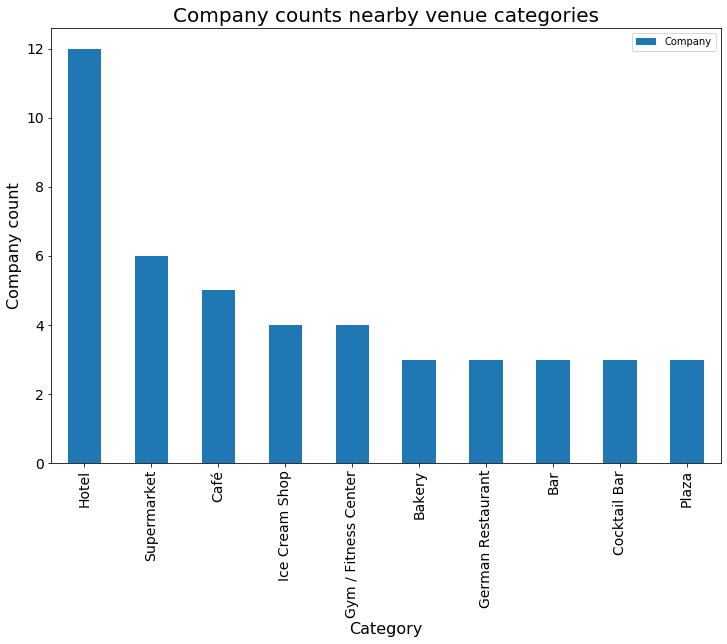

In [48]:
# plot the top_ten_venues as barplot
ax = top_ten_venues.reset_index().plot(x='Category', y='Company', kind="bar", figsize=(12, 8),
                                       fontsize=14)
ax.set_title("Company counts nearby venue categories", fontsize=20)
ax.set_xlabel("Category", fontsize=16)
ax.set_ylabel("Company count", fontsize=16)
plt.show()

### Exploration of the venues nearby the Neighborhoods in Frankfurt
Let's take a short look on how the data of Frankfurt look like (as recap)

In [49]:
frankframe.head()

,ZIP,Neighborhood,latitude,longitude
0,60306,Westend-Süd,50.116106,8.670161
1,60308,Westend-Süd,50.112301,8.652724
2,60310,Innenstadt,49.609911,2.906436
3,60311,"Altstadt, Innenstadt",50.110068,8.683168
4,60312,Innenstadt,50.111555,8.673024


Get the venues of the Neighborhoods via the __Foursquare API__ and use the function like above for wrangling the data.

In [ ]:
venues_per_neighborhood = {}
for row in frankframe.iterrows():
    venues_per_neighborhood[row[1].ZIP] = get_venues_near_location(row[1].latitude, row[1].longitude, client_id, client_secret)

In [55]:
nbh_venues = get_relevant_venue_data(venues_per_neighborhood)

In [48]:
nbh_venues_df = venue_data_to_dataframe(nbh_venues, first_col="PLZ")
nbh_venues_df.head()

<function __main__.venue_data_to_dataframe(all_venues)>

In [52]:
# dump the dataframe to a csv file
# nbh_venues_df.to_csv("fr_neighborhood_venues.csv")
nbh_venues_df = pd.read_csv("fr_neighborhood_venues.csv")

### Venues around the Neighborhood centers of Frankfurt
Get the nearest venue categories to each ZIP (= PLZ in german)

In [55]:
# function to divide the dataframe in Neighborhood pieces and sort it by the lowest distance
top_10_nbh_venues = get_top_10(nbh_venues_df, colum_key="PLZ")

In [58]:
# put all top 10 categories to each ZIP in a dataframe
plz_venues = []
for nv in top_10_nbh_venues:
    plz_venues.append([nv['PLZ'].unique()[0]] + nv['Category'].values.tolist())
    
# append the top 10 venues nearby german data science companies right at the tail of the df
plz_venues.append(["ds_venues"] + top_ten_venues.T.columns.tolist())

# add headers to the columns
neighborhoods_venues = pd.DataFrame(data=plz_venues, columns=['ZIP'] + ["top_{}".format(i + 1) for i in range(10)])
neighborhoods_venues.head()

,ZIP,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
0,60306,Food & Drink Shop,Breakfast Spot,Bistro,Opera House,Plaza,Italian Restaurant,Fountain,Asian Restaurant,Indian Restaurant,French Restaurant
1,60308,Concert Hall,Italian Restaurant,Piano Bar,Drugstore,Indian Restaurant,Coffee Shop,Ramen Restaurant,Hotel,Beer Store,Sandwich Place
2,60311,Art Museum,Café,Plaza,Wine Bar,Café,Pastry Shop,Scenic Lookout,Chocolate Shop,Burger Joint,Café
3,60312,Scenic Lookout,Building,Café,Coffee Shop,Art Museum,Bar,Theater,Hotel,Bar,Bistro
4,60313,Vietnamese Restaurant,Gym / Fitness Center,Market,Wine Bar,Toy / Game Store,Fountain,Restaurant,American Restaurant,Boutique,Hotel


In [60]:
neighborhoods_venues.tail(2)

,ZIP,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
40,65936,Nightclub,Bus Stop,Ice Cream Shop,Supermarket,Shipping Store,Bakery,Supermarket,German Restaurant,Intersection,Fast Food Restaurant
41,ds_venues,Hotel,Supermarket,Café,Ice Cream Shop,Gym / Fitness Center,Bakery,German Restaurant,Bar,Cocktail Bar,Plaza


### Machine Learning Part - Let's cluster the dataframe
To find out which of the neighborhoods in Frankfurt is most similar to the locations of the data sicence companies (__*ldsc*__), the idea was to group the neighborhoods using __KMeans clustering__ with the venues as features. If we look at the cluster containing the __*ldsc*__ and are lucky, we see some candidate neighborhoods for our data science Sart-Up.

In [61]:
# import sklearn stuff
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

To use the venues as features for our clustering algorithm, we have to encode the category strings into numeric values. 
1. In sklearn there is already a implemented encoder (__OrdinalEncoder__)
1. Using the __StandardScaler__ from sklearn lets our model perform well
1. Get the right hyperparameters for our __KMeans__ algorithm using __GridSearchCV__ 

In [63]:
# encode the venues to numerical values
le = OrdinalEncoder()
encoded = le.fit_transform(neighborhoods_venues.loc[:, 'top_1':].astype(str))
std_encoded = StandardScaler().fit_transform(encoded)
std_encoded[:5]

array([[-0.75600535, -1.22068356, -1.60606568,  0.65437566,  0.52985714,
         0.43511448, -0.84657068, -1.30293402,  0.81391012, -0.5021395 ],
       [-0.98693063,  0.19986003,  0.55248659, -0.51741331, -0.24132107,
        -0.69996677,  0.63053187,  0.05758824, -1.20390872,  1.50641851],
       [-1.79516908, -0.70412226,  0.68739611,  1.61311209, -1.01249929,
         1.0026551 ,  0.84154652, -0.54708832, -0.72912782, -1.36295008],
       [ 0.62954628, -1.09154323, -1.47115616, -0.83699212, -1.56334087,
        -1.15399926,  1.47459047,  0.05758824, -1.32260395, -1.64988694],
       [ 1.55324736, -0.31670128,  0.01284853,  1.61311209,  1.52137199,
        -0.35944239,  0.7360392 , -1.6052723 , -0.84782304, -0.21520264]])

In [66]:
# build the GridSearchCV model and the params grid
params = {
    'n_clusters': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_init': [10, 15, 20, 25, 30],
    'tol': [0.0001, 0.001, 0.01]
}
gv = GridSearchCV(KMeans(), params, cv=3)

In [67]:
# fit the model
gv.fit(std_encoded)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++',
                              max_iter=300, n_clusters=8, n_init=10,
                              n_jobs=None, precompute_distances='auto',
                              random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'n_clusters': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_init': [10, 15, 20, 25, 30],
                         'tol': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [68]:
# get the best KMeans model
gv.best_estimator_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [69]:
# let's predict the clusters
cluster = gv.best_estimator_.predict(std_encoded)

In [72]:
# concatenate the clusters as column to the neighborhoods_venues dataframe
clustered_venues = pd.concat([neighborhoods_venues, pd.DataFrame(data=cluster, columns=['cluster'])], axis=1)

# take a look at the cluster number of ds_venues
clustered_venues

,ZIP,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,cluster
0,60306,Food & Drink Shop,Breakfast Spot,Bistro,Opera House,Plaza,Italian Restaurant,Fountain,Asian Restaurant,Indian Restaurant,French Restaurant,7
1,60308,Concert Hall,Italian Restaurant,Piano Bar,Drugstore,Indian Restaurant,Coffee Shop,Ramen Restaurant,Hotel,Beer Store,Sandwich Place,1
2,60311,Art Museum,Café,Plaza,Wine Bar,Café,Pastry Shop,Scenic Lookout,Chocolate Shop,Burger Joint,Café,6
3,60312,Scenic Lookout,Building,Café,Coffee Shop,Art Museum,Bar,Theater,Hotel,Bar,Bistro,5
4,60313,Vietnamese Restaurant,Gym / Fitness Center,Market,Wine Bar,Toy / Game Store,Fountain,Restaurant,American Restaurant,Boutique,Hotel,3
5,60314,Pizza Place,Intersection,Fried Chicken Joint,Tram Station,Motorcycle Shop,Kids Store,IT Services,Currywurst Joint,Furniture / Home Store,Sporting Goods Shop,2
6,60316,Modern European Restaurant,Café,Plaza,Italian Restaurant,Café,Japanese Restaurant,Plaza,Currywurst Joint,Bakery,Café,1
7,60318,Gym / Fitness Center,Pizza Place,Ice Cream Shop,Hotel,Indie Movie Theater,Café,Vietnamese Restaurant,Café,Café,Ice Cream Shop,1
8,60320,Pizza Place,Soccer Field,Park,Vegetarian / Vegan Restaurant,Bakery,Concert Hall,Mediterranean Restaurant,Park,Hockey Field,Italian Restaurant,3
9,60322,Beer Garden,Portuguese Restaurant,Health Food Store,Health Food Store,Italian Restaurant,Greek Restaurant,Café,Park,Falafel Restaurant,Italian Restaurant,4


In [ ]:
# map the clusters of Frankfurt data only with folium

In [73]:
# filter the dataframe for the cluster number of ds_venues
clustered_venues[clustered_venues['cluster'] == 7]

,ZIP,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10,cluster
0,60306,Food & Drink Shop,Breakfast Spot,Bistro,Opera House,Plaza,Italian Restaurant,Fountain,Asian Restaurant,Indian Restaurant,French Restaurant,7
14,60329,Burger Joint,Drugstore,Asian Restaurant,Malay Restaurant,Indian Restaurant,Convenience Store,Bakery,Bar,Burger Joint,Indian Restaurant,7
41,ds_venues,Hotel,Supermarket,Café,Ice Cream Shop,Gym / Fitness Center,Bakery,German Restaurant,Bar,Cocktail Bar,Plaza,7


Finally we found __2__ candidate locations in Frankfurt for our data science Start-Up!

In [ ]:
# get the neighborhood names 

In [17]:
# To be continued

## Results

In [18]:
# To be continued

## Discussion

In [19]:
# To be continued

## Conclusion

In [20]:
# To be continued